# Research Methods - Assignment 1

- André Santos
- Luís Espírito Santo
- Miguel Guerreiro

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits import mplot3d

## Read Data

In [ ]:
!gdown --id 1YHqFfWV976RBm4rv0mtKmjMAeWRwACX4

Downloading...
From: https://drive.google.com/uc?id=1YHqFfWV976RBm4rv0mtKmjMAeWRwACX4
To: /content/measurements_v1.csv
100% 57.5k/57.5k [00:00<00:00, 21.1MB/s]


In [ ]:
df = pd.read_csv("measurements_v1.csv", index_col=0)
df.describe()

,Exams,Percentage,Solution_code1,Solution_code2,Time_code1,Time_code2
count,2020.000000,2020.00000,1010.000000,1010.000000,1010.000000,1010.000000
mean,9.500000,0.50000,3.605941,3.655446,0.938088,0.989847
std,2.872993,0.29162,1.996817,1.943222,14.282847,14.590168
min,5.000000,0.00000,-1.000000,-1.000000,0.000008,0.000004
25%,7.000000,0.25000,2.000000,2.000000,0.000025,0.000008
50%,9.500000,0.50000,3.000000,3.000000,0.000048,0.000016
75%,12.000000,0.75000,4.000000,4.000000,0.000135,0.000079
max,14.000000,1.00000,13.000000,13.000000,300.000001,300.000001


## 3D Scatter

In [ ]:
mean_d = df.groupby(["Exams", "Percentage"]).mean().reset_index()
mean_d

,Exams,Percentage,Solution_code1,Solution_code2,Time_code1,Time_code2
0,5,0.00,1.0,2.0,0.000012,0.000004
1,5,0.01,1.0,2.0,0.000013,0.000004
2,5,0.02,1.0,2.0,0.000012,0.000004
3,5,0.03,1.0,2.0,0.000012,0.000005
4,5,0.04,1.0,2.0,0.000015,0.000007
...,...,...,...,...,...,...
1005,14,0.96,12.0,12.0,46.831595,35.859339
1006,14,0.97,12.0,12.0,19.509312,25.250443
1007,14,0.98,13.0,13.0,130.185015,141.858020
1008,14,0.99,-1.0,-1.0,300.000001,300.000001


In [ ]:
(df.groupby(["Exams", "Percentage"]).count() > 1).any()

Solution_code1    False
Solution_code2    False
Time_code1        False
Time_code2        False
dtype: bool

In [ ]:
(df.groupby(["Exams", "Percentage"]).count() < 1).any()

Solution_code1    False
Solution_code2    False
Time_code1        False
Time_code2        False
dtype: bool

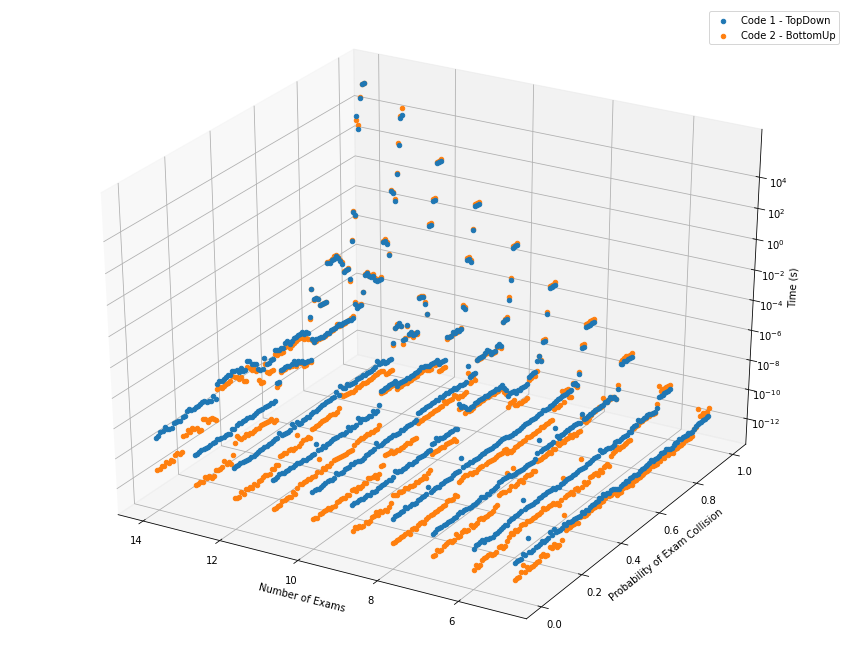

In [ ]:
#Plot 3D scatter

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.invert_xaxis()

# Data for three-dimensional scattered points
for code, color, desc  in [(1, "Blues", "TopDown"), (2, "Oranges", "BottomUp")]:
  zdata = np.log(mean_d["Time_code{}".format(code)])
  xdata = mean_d["Exams"]
  ydata = mean_d["Percentage"]
  s = ax.scatter3D(xdata, ydata, zdata, depthshade=False, cmap=color);
  s.set_label('Code {} - {}'.format(code, desc))

ticks = np.arange(0, 20, 2) - 14
tick_labels = [r'$10^{%i}$'%(i) for i in ticks]

ax.set_zticks(ticks)
ax.set_zticklabels(tick_labels)
ax.set_xlabel('Number of Exams')
ax.set_ylabel('Probability of Exam Collision')
ax.set_zlabel('Time (s)')
ax.legend()